In [18]:
import os
import numpy as np
from PIL import Image
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class CIFAR10Custom(Dataset):
    def __init__(self, root_dir, batch_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        for batch_file in batch_files:
            file_path = os.path.join(root_dir, batch_file)
            batch_data = unpickle(file_path)
            self.data.append(batch_data[b'data'])
            self.labels.extend(batch_data[b'labels'])
            
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [19]:
data_root = "/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/"  # 替换成你的实际路径

train_dataset = CIFAR10Custom(
    root_dir=data_root,
    batch_files=['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5'],
    transform=train_transform
)

test_dataset = CIFAR10Custom(
    root_dir=data_root,
    batch_files=['test_batch'],  # 假设测试集文件名为test_batch
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4
)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_epochs = 100
learning_rate = 0.01
num_classes = 10

In [21]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3,
            stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3,
            stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [22]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes).to(device)
summary(model, (3, 32, 32))

#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)#把SGD改成了AdamW
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)#换了个余弦退火试试
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

train_losses = []
test_losses = []
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100.*correct/total

    acc = 100.*correct/total
    print(f'Epoch: {epoch} | Loss: {train_loss/(batch_idx+1):.3f} | Acc: {acc:.2f}%')
    train_losses.append(train_loss/(batch_idx+1))

    return acc

def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    print(f'Test Accuracy: {acc:.2f}%')
    test_losses.append(test_loss/(batch_idx+1))
    return acc

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
train_accs, test_accs = [], []
patience = 5
best_acc = 0
counter = 0
for epoch in range(num_epochs):
    train_acc = train(epoch)
    test_acc = test()
    
    #scheduler.step()

    scheduler.step(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

Epoch: 0 | Loss: 1.648 | Acc: 46.26%
Test Accuracy: 46.48%
Epoch: 1 | Loss: 1.275 | Acc: 65.34%
Test Accuracy: 68.61%
Epoch: 2 | Loss: 1.112 | Acc: 73.13%
Test Accuracy: 74.10%
Epoch: 3 | Loss: 1.020 | Acc: 77.47%
Test Accuracy: 72.84%
Epoch: 4 | Loss: 0.963 | Acc: 80.15%
Test Accuracy: 76.90%
Epoch: 5 | Loss: 0.919 | Acc: 82.22%
Test Accuracy: 80.31%
Epoch: 6 | Loss: 0.890 | Acc: 83.42%
Test Accuracy: 82.43%
Epoch: 7 | Loss: 0.858 | Acc: 84.68%
Test Accuracy: 82.61%
Epoch: 8 | Loss: 0.836 | Acc: 85.79%
Test Accuracy: 83.94%
Epoch: 9 | Loss: 0.812 | Acc: 86.84%
Test Accuracy: 83.49%
Epoch: 10 | Loss: 0.799 | Acc: 87.21%
Test Accuracy: 85.24%
Epoch: 11 | Loss: 0.781 | Acc: 88.10%
Test Accuracy: 84.76%
Epoch: 12 | Loss: 0.766 | Acc: 88.86%
Test Accuracy: 85.24%
Epoch: 13 | Loss: 0.757 | Acc: 89.14%
Test Accuracy: 86.18%
Epoch: 14 | Loss: 0.741 | Acc: 89.81%
Test Accuracy: 86.26%
Epoch: 15 | Loss: 0.736 | Acc: 90.11%
Test Accuracy: 86.59%
Epoch: 16 | Loss: 0.723 | Acc: 90.67%
Test Accurac

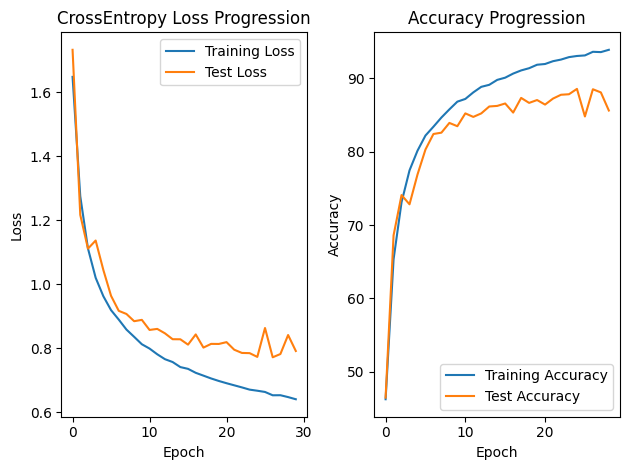

In [24]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('CrossEntropy Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy Progression')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

class CIFAR10TestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform:
            image = self.transform(image)
        return image

def generate_submission():
    test_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
    
    def test_transform_nolabel():
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ])
    
    with open(test_file, 'rb') as f:
        test_data = pickle.load(f, encoding='bytes')
    
    images = test_data[b'data']

    test_dataset = CIFAR10TestDataset(images, transform=test_transform_nolabel())
    test_loader_nolabel = DataLoader(test_dataset, batch_size=100, shuffle=False)
    
    model.eval()
    predictions = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader_nolabel:
            inputs = batch.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    submission = pd.DataFrame({
        'ID': range(len(predictions)),
        'Labels': predictions
    })
    submission.to_csv('submission.csv', index=False)
    print(f"生成提交文件完成，首5条记录：\n{submission.head()}")
    return submission

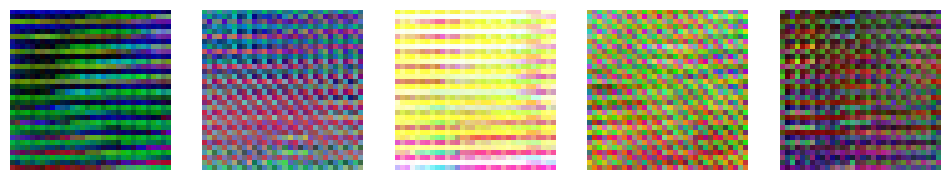

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image

train_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
#train_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1'

with open(train_file, 'rb') as f:
    train_data = pickle.load(f, encoding='bytes')

images = train_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # (N, 32, 32, 3)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")

plt.show()


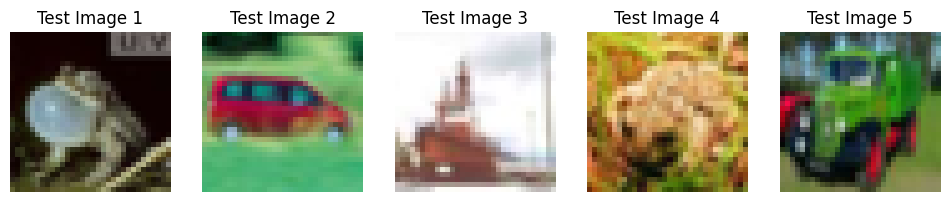

In [27]:
import matplotlib.pyplot as plt
import pickle

test_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
with open(test_file, 'rb') as f:
    test_data = pickle.load(f, encoding='bytes')

images = test_data[b'data']

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Test Image {i+1}")
    axes[i].axis("off")

plt.show()

In [28]:
final_submission = generate_submission()

生成提交文件完成，首5条记录：
   ID  Labels
0   0       6
1   1       1
2   2       8
3   3       6
4   4       9
